# Predicción de la demanda de bicicletas – Regresión Polinomial y Lasso

## 1. Introducción

En el contexto del cambio climático y la necesidad de promover estrategias de movilidad sostenible, resulta fundamental comprender los factores que influyen en el uso de sistemas de alquiler de bicicletas. 

Este proyecto tiene como objetivo construir modelos predictivos que permitan estimar la demanda de bicicletas utilizando técnicas de regresión, siguiendo el ciclo completo de Machine Learning: exploración, limpieza, modelado, validación y evaluación.

Se implementaron dos enfoques:
- Regresión Polinomial
- Regresión Regularizada Lasso

Además de comparar su desempeño, se analiza la importancia de las variables seleccionadas por el modelo Lasso para extraer conclusiones relevantes para la toma de decisiones.


### 0. Importe de librerias

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.pipeline import make_pipeline
from importlib.metadata import version
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

#### 00. Cargue de datos

In [4]:
ruta = r'C:\Users\WINDOWS\Documents\MAIA\py1dataa.csv'
data_raw = pd.read_csv(ruta)

In [5]:
data_raw.shape

(17379, 9)

In [6]:
data_raw.head(5)

,season,weekday,weathersit,temp,atemp,hum,windspeed,cnt,time_of_day
0,Winter,6,Clear,3.28,3.0014,0.81,0.0,16,Night
1,Winter,6,Clear,2.34,1.9982,0.80,0.0,40,Night
2,Winter,6,Clear,2.34,1.9982,0.80,0.0,32,Night
3,Winter,6,Clear,3.28,3.0014,0.75,0.0,13,Night
4,Winter,6,Clear,3.28,3.0014,0.75,0.0,1,Night


In [7]:
data = data_raw.copy()

## 2. Exploración y perfilamiento de los datos

Se realizó un análisis exploratorio utilizando la librería pandas con el objetivo de:

- Identificar valores faltantes
- Detectar registros duplicados
- Revisar tipos de datos
- Analizar estadísticas descriptivas

El conjunto de datos contiene 17,380 registros, lo cual proporciona una base suficiente para entrenar modelos predictivos robustos.

Durante esta etapa se evaluó la coherencia de las variables meteorológicas, temporales y de demanda, con el fin de detectar posibles problemas de calidad que pudieran afectar el desempeño de los modelos.


In [8]:
data.isna().sum()

season         0
weekday        0
weathersit     0
temp           0
atemp          0
hum            0
windspeed      0
cnt            0
time_of_day    0
dtype: int64

In [9]:
data.duplicated().sum()

np.int64(42)

Se decide eliminar los 42 registros duplicados.

In [10]:
data = data.drop_duplicates()

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17337 entries, 0 to 17378
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   season       17337 non-null  object 
 1   weekday      17337 non-null  int64  
 2   weathersit   17337 non-null  object 
 3   temp         17337 non-null  float64
 4   atemp        17337 non-null  float64
 5   hum          17337 non-null  float64
 6   windspeed    17337 non-null  float64
 7   cnt          17337 non-null  int64  
 8   time_of_day  17337 non-null  object 
dtypes: float64(4), int64(2), object(3)
memory usage: 1.3+ MB


Se evidencia que el dataset contiene 3 variables de tipo categorica 'season', 'weathersit' y 'time_of_day'. (dtype = object).  4 variables numericas continuas (temp, atemp, hum, windspeed) tipo float y 2 tipo int (cnt y weekday).

**2.1 Exploración datos númericos**

In [12]:
data.describe()

,weekday,temp,atemp,hum,windspeed,cnt
count,17337.000000,17337.000000,17337.000000,17337.000000,17337.000000,17337.000000
mean,3.005076,15.373723,15.419489,0.626924,12.744552,189.865836
std,2.006156,9.046797,11.338895,0.192857,8.196736,181.400275
min,0.000000,-7.060000,-16.000000,0.000000,0.000000,1.000000
25%,1.000000,7.980000,5.997800,0.480000,7.001500,40.000000
50%,3.000000,15.500000,15.996800,0.630000,12.998000,143.000000
75%,5.000000,23.020000,24.999200,0.780000,16.997900,281.000000
max,6.000000,39.000000,50.000000,1.000000,56.996900,977.000000


**Observaciones:**

* **Weekday:** Aunque es clasificada como numerica por describe(), esta es una representacion numerica secuencial, es decir etiquetas de una variable categorica ordinal. La variable 'weekday' tiene una codificacion de [0,6]. Se asume que 0 corresponde al primer día del ciclo semanal definido en el diccionario. 
* **Temp:** Los valores de temperatura parecen estar registrados en grados Celsius.
* **Hum:** Los valores de humedad estan normalizados y arrojan datos entre [0,1]
* **Windspeed:** Los valores de velocidad de viento se encuentran entre [0,57]. Al observar que el tercer cuartil (Q3) es de 16.99, existe una sospecha clara de valores atípicos. Aplicando el criterio del Rango Intercuartílico (IQR), se establece un límite máximo esperado de 31.97. Dado que el maximo fue 57, se confirma la presencia de valores atipicos significativos. 
* **CNT:** Los valores de renta de bicicletas se encuentran entre [1,977] unidades. Variable predictora
 

**Gráficas variables númericas**

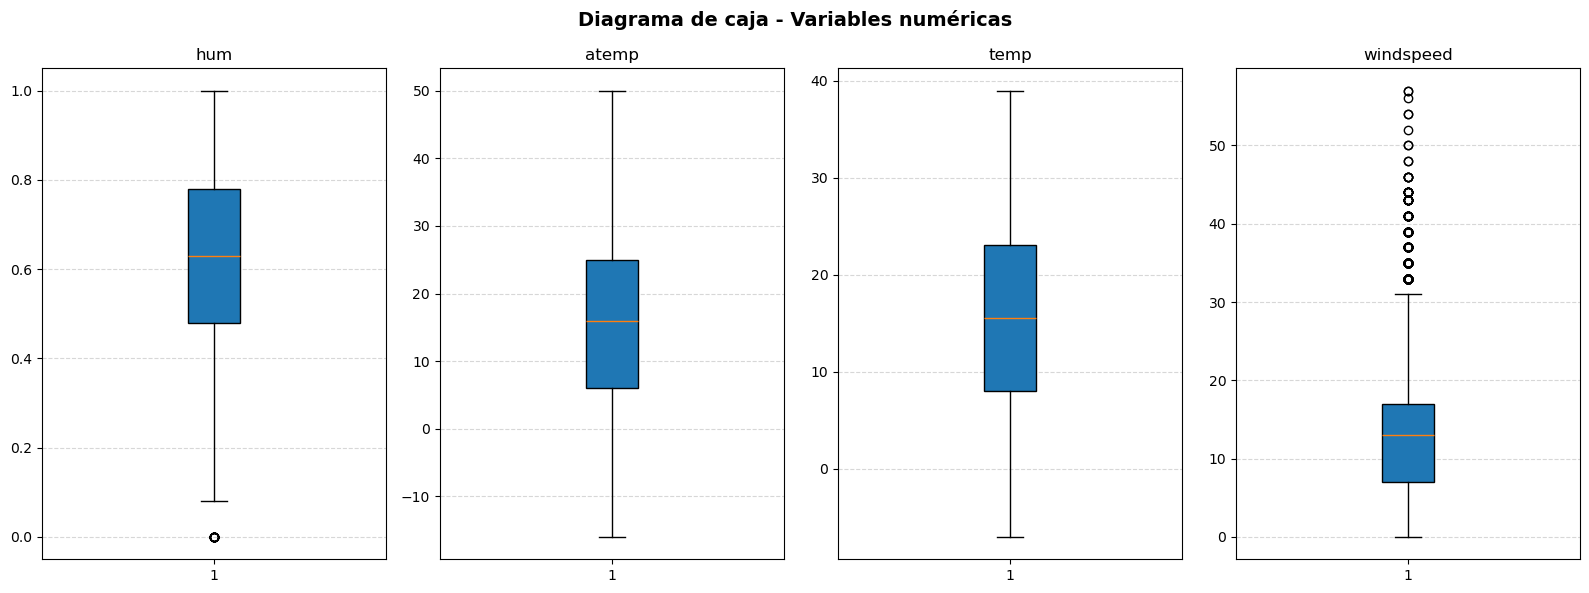

In [13]:
fig, axes = plt.subplots(1, 4, figsize=(16, 6))
fig.suptitle('Diagrama de caja - Variables numéricas', fontsize=14, fontweight='bold')

variables = ['hum', 'atemp', 'temp', 'windspeed']

for ax, var in zip(axes, variables):
    ax.boxplot(data[var], patch_artist=True)
    ax.set_title(var)
    ax.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

A partir del diagrama de cajas, se observa la presencia de valores tipicos para los datos de la variable 'windspeed'. 

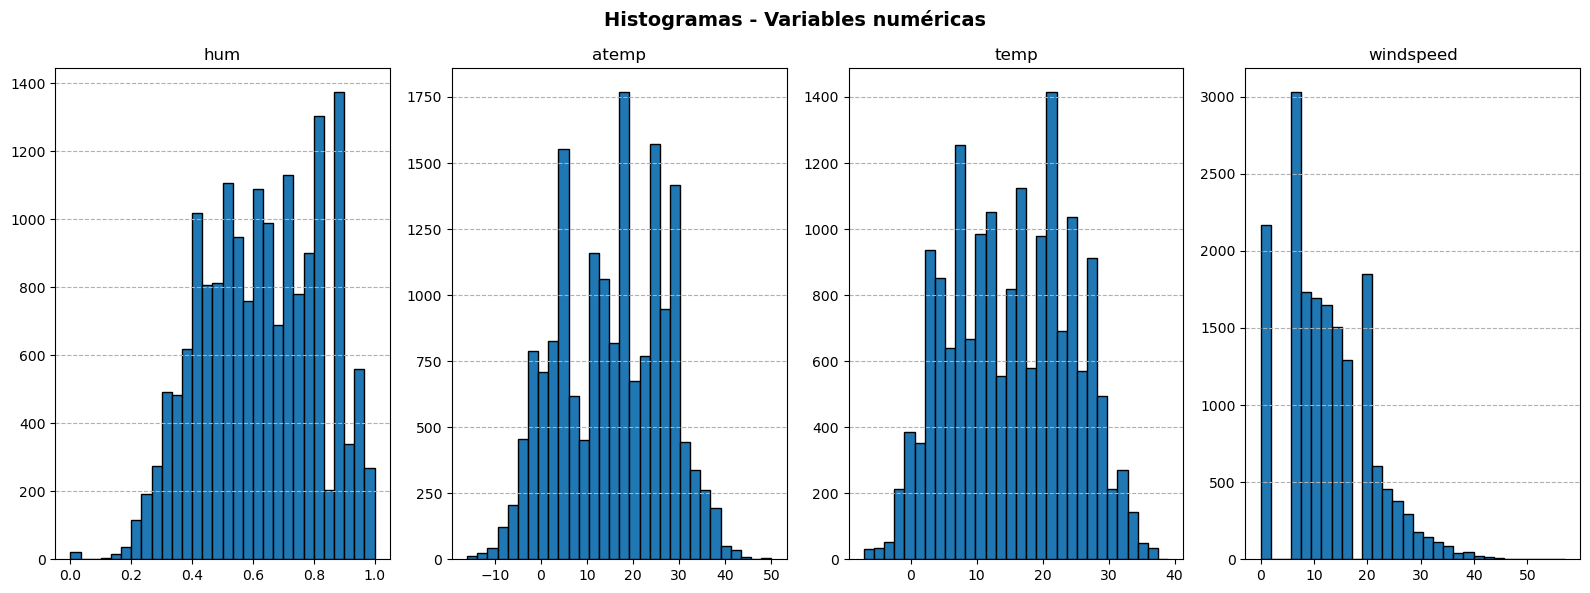

In [20]:
fig, axes = plt.subplots(1, 4, figsize=(16, 6))
fig.suptitle('Histogramas - Variables numéricas', fontsize=14, fontweight='bold')

variables = ['hum', 'atemp', 'temp', 'windspeed']

for ax, var in zip(axes, variables):
    ax.hist(data[var], bins=30, edgecolor='black')
    ax.set_title(var)
    ax.grid(axis='y', linestyle='--')

plt.tight_layout()
plt.show()

Se observa que hum, atemp y temp tienen una distribuccion relativamente equilibrada de lo datos, mientras windspee presenta asimetria, lo cual coincide con la presencia de outliers hallados anteriormente. 

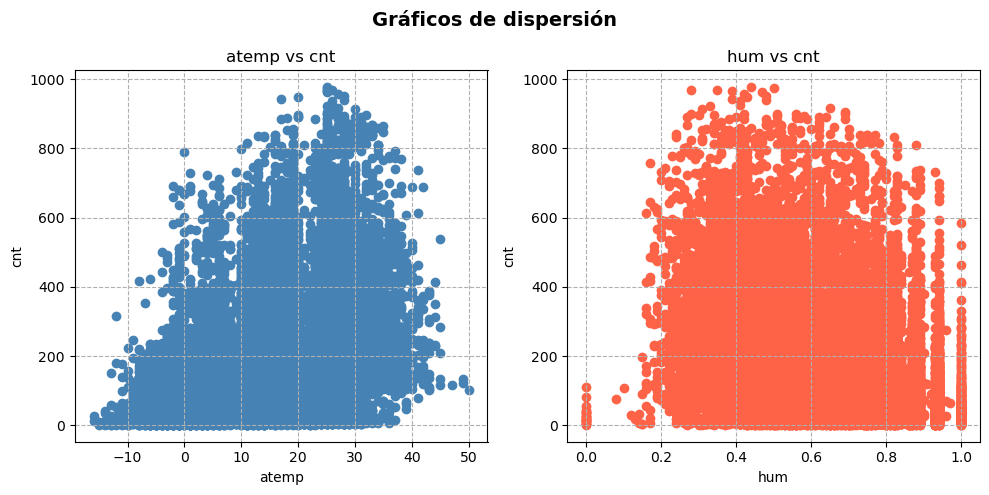

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Gráficos de dispersión', fontsize=14, fontweight='bold')

variables = [('atemp', 'steelblue'), ('hum', 'tomato')]

for ax, (var, color) in zip(axes, variables):
    ax.scatter(data[var], data['cnt'], color=color)
    ax.set_title(f'{var} vs cnt')
    ax.set_xlabel(var)
    ax.set_ylabel('cnt')
    ax.grid(linestyle='--')

plt.tight_layout()
plt.show()

Se observa bastante variabilidad en los datos debida al tamaño del dataset. Sin embargo, se aprecia una relación positiva, aunque no lineal entre atemp y cnt. 
Mientras que entre hum y cnt, se observa que valores de humedad bajos/medios producen altos picos de demanda. Posible relación negativa 

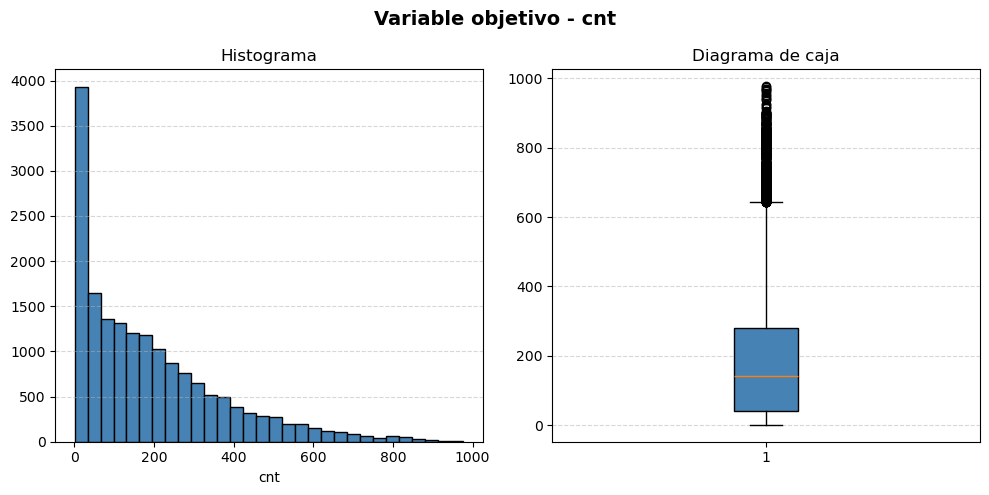

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('Variable objetivo - cnt', fontsize=14, fontweight='bold')

axes[0].hist(data['cnt'], bins=30, edgecolor='black', color='steelblue')
axes[0].set_title('Histograma')
axes[0].set_xlabel('cnt')
axes[0].grid(axis='y', linestyle='--', alpha=0.5)

axes[1].boxplot(data['cnt'], patch_artist=True, boxprops=dict(facecolor='steelblue'))
axes[1].set_title('Diagrama de caja')
axes[1].grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

El histograma muestra que la la mayoria de datos se concentran en valores de demanda bajos y medios. Hay baja frecuencia al aumentar progresivamente el numero de alquileres, lo que indica picos de alta demanda. 

**2.2 Correlación**

Se obtiene el calculo de correlaciones entre todas las variables del dataset, con el fin de verificar multicolinealidad que pueda afectar el modelo y observar que impacto estimado se espera que tengan las variables sobre la variable objetivo. 

            weekday      temp     atemp       hum  windspeed       cnt
weekday    1.000000 -0.002149 -0.009138 -0.036776   0.011014  0.026401
temp      -0.002149  1.000000  0.987660 -0.069881  -0.023781  0.404155
atemp     -0.009138  0.987660  1.000000 -0.051948  -0.062856  0.400335
hum       -0.036776 -0.069881 -0.051948  1.000000  -0.290057 -0.322245
windspeed  0.011014 -0.023781 -0.062856 -0.290057   1.000000  0.092539
cnt        0.026401  0.404155  0.400335 -0.322245   0.092539  1.000000


<Axes: >

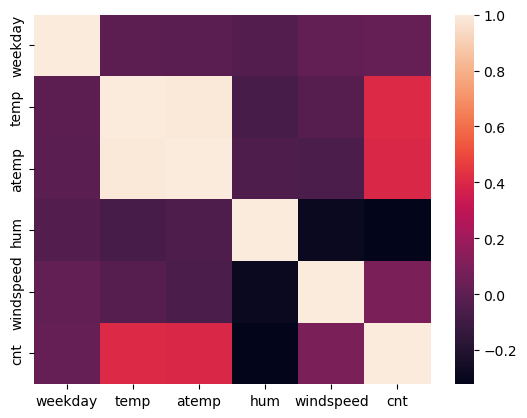

In [14]:
print(data.select_dtypes(include='number').corr())
sns.heatmap(data.corr(numeric_only=True))

Dado que se presento una correlacion fuerte del 0.98 entre las variable 'temp' : Temperatura y 'atemp' : Sensacion de temperatura, se toma la decisión de eliminar la columna 'temp' del dataset. De modo que se evita incurrir en multicolinealidad.

Adicionalmente, cabe notar que la correlación entre winspeed y cnt es baja, del 0.09, lo cual indicaria que su influencia sobre la demanda de bicicletas es limitada. 

Se preserva la sensacion de temperatura debido a que es la que se podria relacionar de manera mas directa con la decision del usuario de alquiler bicicletas.

In [15]:
data = data.drop(['temp'], axis = 'columns')
data.head()

,season,weekday,weathersit,atemp,hum,windspeed,cnt,time_of_day
0,Winter,6,Clear,3.0014,0.81,0.0,16,Night
1,Winter,6,Clear,1.9982,0.80,0.0,40,Night
2,Winter,6,Clear,1.9982,0.80,0.0,32,Night
3,Winter,6,Clear,3.0014,0.75,0.0,13,Night
4,Winter,6,Clear,3.0014,0.75,0.0,1,Night


**2.3 Exploracion datos categoricos**

Se reemplazan las etiquetas tipo int de la variable 'weekday' por los dias de la semana correspondiente, con el objetivo que sean analizados como variables categoricas.

In [64]:
dias = {
    0: "L",
    1: "M",
    2: "X",
    3: "J",
    4: "V",
    5: "S",
    6: "D"
}

data['weekday'] = data['weekday'].map(dias)

In [65]:
data.describe(include= object)

,season,weekday,weathersit,time_of_day
count,17337,17337,17337,17337
unique,4,7,4,3
top,Summer,D,Clear,Night
freq,4490,2509,11389,6442


In [66]:
data['season'].value_counts()

season
Summer    4490
Spring    4400
Winter    4226
Fall      4221
Name: count, dtype: int64

In [68]:
data['weathersit'].value_counts()

weathersit
Clear         11389
Mist           4535
Light Rain     1410
Heavy Rain        3
Name: count, dtype: int64

Se observa que existen muy pocos datos correspondientes a 'Heavy Rain' lo que podria afectar el modelo. Por consiguiente, se decide unificar el valor de los datos de 'Light Rain' y 'Heaavy Rain' en 'Rain', sin perder información esencial. 

Se realiza el reemplazo en la columna. 

In [69]:
agrupar_rain = {
    'Light Rain': 'Rain',
    'Heavy Rain': 'Rain'
}
data['weathersit'] = data['weathersit'].replace(agrupar_rain)

In [70]:
data['weathersit'].value_counts()

weathersit
Clear    11389
Mist      4535
Rain      1413
Name: count, dtype: int64

Se observa que ahora la variable 'weathersit' puede tomar 3 valores: 'Clear', 'Mist' y 'Rain'.

In [71]:
data['time_of_day'].value_counts()

time_of_day
Night      6442
Morning    5797
Evening    5098
Name: count, dtype: int64

In [72]:
data['weekday'].value_counts()

weekday
D    2509
L    2495
S    2484
M    2473
J    2468
V    2466
X    2442
Name: count, dtype: int64

**Gráficas de variables categoricas**

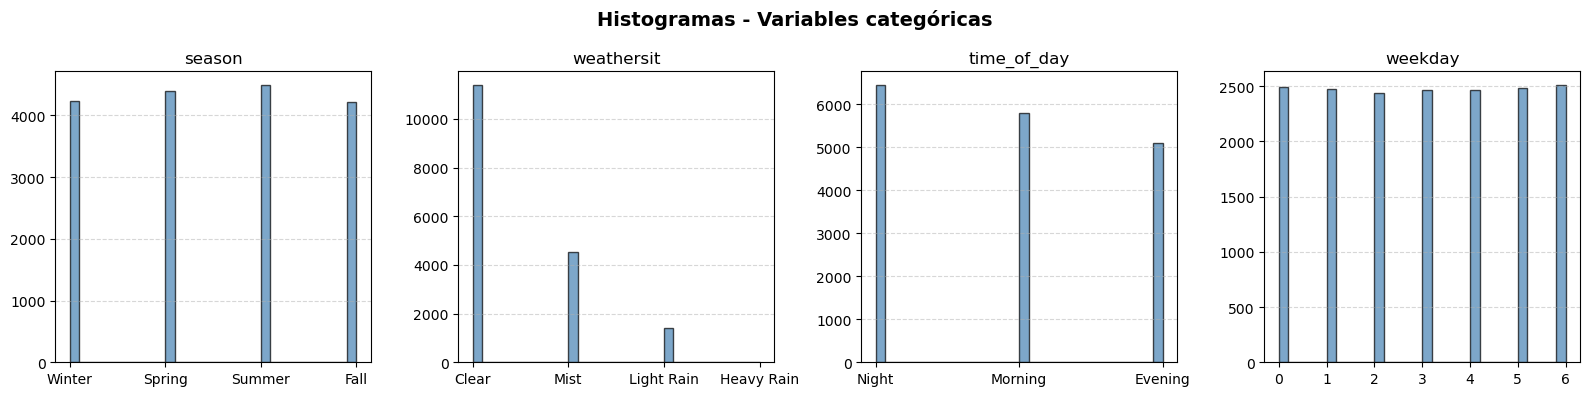

In [26]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
fig.suptitle('Histogramas - Variables categóricas', fontsize=14, fontweight='bold')

variables = ['season', 'weathersit', 'time_of_day', 'weekday']

for ax, var in zip(axes, variables):
    ax.hist(data[var], bins=30, edgecolor='black', color='steelblue', alpha=0.7)
    ax.set_title(var)
    ax.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

Para season y weekday, se observa un distribuccion equilibrada por lo que el dataset contiene registros tomados uniformemente a lo largo del año para estas variables. 

Por el contrario, para weathersit, se evidencia que la mayoria de datos fueron tomados para dias con clima despejado, lo que puede provocar un sesgo en las predicciones haciendolo menos preciso para 'clima lluvioso'.




## 3. Limpieza y preparación de los datos

Con base en el análisis exploratorio, se realizaron las siguientes acciones:

- Conversión de variables categóricas cuando fue necesario
- Separación del conjunto de datos en entrenamiento y prueba utilizando una semilla fija (random_state = 77), garantizando reproducibilidad

Estas decisiones fueron tomadas con el objetivo de asegurar la calidad de los datos y evitar sesgos en el entrenamiento del modelo.


In [74]:
x = data.drop(['cnt'], axis = 'columns')
y = data['cnt']

In [75]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state = 77)
print(f'tamaño x_train:{x_train.shape}')
print(f'tamaño x_test:{x_test.shape}')

tamaño x_train:(13869, 8)
tamaño x_test:(3468, 8)


Dado que se habian identificado 4 variables categoricas ('time_of_day', 'weekday','weathersit','season'), es necesario convertirlas en vectores numericos binarios, de manera que puedan ser interpretables para el modelo. 

Adicionalmente, para el caso de las variables numericas se aplica la transformación RobustScaler(), debido a que en la fase exploratoria se encontro que habian datos a difrentes escalas y otros con multiples outliers (winspeed) que podrian potencialmente afectar el entrenamiento. 

- OneHotEncoder para las variables categoricas (season, weathersit, time_of_day, weekday)
- train_test_split con 80/20 y random_state=77
- ColumnTransformer para aplicar las transformaciones de forma ordenada, posterior al split para evitar data snooping.

In [76]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
lista_cat = ['weekday','time_of_day','season','weathersit']
lista_num = ['atemp','hum','windspeed']
ohe = ColumnTransformer(
    transformers=[
        ('ohe', encoder, lista_cat),
        ('scaler', RobustScaler(), lista_num)
    ]
)
x_train_prep = ohe.fit_transform(x_train)
x_test_prep = ohe.transform(x_test)


columnas_finales = ohe.get_feature_names_out()
x_train_prep = pd.DataFrame(x_train_prep, columns=columnas_finales)
x_test_prep = pd.DataFrame(x_test_prep, columns=columnas_finales)

## 4. Modelo de Regresión Polinomial

Se construyó un modelo de regresión polinomial con el fin de capturar posibles relaciones no lineales entre las variables predictoras y la demanda de bicicletas.

Para seleccionar el grado óptimo del polinomio se evaluaron los siguientes valores:

- Grado 2
- Grado 3

La selección del modelo se realizó utilizando la métrica RMSE, priorizando el modelo con menor error en validación.


In [77]:
polynomial_regression = make_pipeline(
    PolynomialFeatures(),
    LinearRegression()
)
kfold_p = KFold(n_splits=10, shuffle=True, random_state = 77)
valores = [2, 3]
param_grid_p = {'polynomialfeatures__degree':valores}

Se utiliza GridSearhCV con el párametros scoring = 'neg_mean_squared_error', debido a que se espera utilizar para la selección la métrica RMSE.

In [78]:
grid_p = GridSearchCV(polynomial_regression,param_grid_p,cv=kfold_p,scoring= 'neg_root_mean_squared_error')

In [79]:
grid_p.fit(x_train_prep,y_train)

,estimator,Pipeline(step...egression())])
,param_grid,"{'polynomialfeatures__degree': [2, 3]}"
,scoring,'neg_root_mean_squared_error'
,n_jobs,None
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,degree,3


In [31]:
print("Mejor parámetro: ", grid_p.best_params_)

Mejor parámetro:  {'polynomialfeatures__degree': 3}


In [32]:
mejor_modelo_p = grid_p.best_estimator_

## 5. Modelo de Regresión Regularizada Lasso

Se implementó un modelo de regresión Lasso, el cual incorpora regularización L1. Este tipo de regularización permite:

- Reducir el sobreajuste
- Penalizar coeficientes grandes
- Realizar selección automática de variables

Para la selección del hiperparámetro α se evaluaron los siguientes valores:

- α = 1
- α = 2
- α = 3
- α = 4
- α = 5

La selección se realizó utilizando la métrica RMSE, eligiendo el valor que minimizara el error en validación.


In [80]:
lasso = Lasso(max_iter=500)
param_grid_l = {'alpha': [1, 2, 3, 4, 5]}
kfold = KFold(n_splits=10, shuffle=True, random_state = 77)
modelos_grid_l = GridSearchCV(lasso, param_grid_l, cv=kfold, n_jobs=-1,verbose=2,scoring= 'neg_root_mean_squared_error')

In [81]:
%%time
modelos_grid_l.fit(x_train_prep, y_train)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
CPU times: total: 172 ms
Wall time: 6.03 s


,estimator,Lasso(max_iter=500)
,param_grid,"{'alpha': [1, 2, ...]}"
,scoring,'neg_root_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,alpha,1


In [82]:
print("Mejor parámetro: ", modelos_grid_l.best_params_)

Mejor parámetro:  {'alpha': 1}


In [83]:
mejor_modelo_l = modelos_grid_l.best_estimator_

## 6. Lasso: Modelo selector de variables

Se utiliza alpha = 1, de acuerdo con el resultado de la busqueda del hiperparametro del punto anterior. De manera, que no penalice en exceso llevando a 0 la mayoria, si no todas, las variables.

In [89]:
lasso_sv = Lasso(alpha=1)

In [90]:
%%time
lasso_sv.fit(x_train_prep, y_train)

CPU times: total: 31.2 ms
Wall time: 77.7 ms


,alpha,1
,fit_intercept,True
,precompute,False
,copy_X,True
,max_iter,1000
,tol,0.0001
,warm_start,False
,positive,False
,random_state,None
,selection,'cyclic'


In [91]:
ans = pd.DataFrame(zip(x_train_prep.columns, lasso_sv.coef_),columns=["Variable","Coeficiente"])
print(ans)

                    Variable  Coeficiente
0             ohe__weekday_D     0.000000
1             ohe__weekday_J     0.000000
2             ohe__weekday_L    -2.260271
3             ohe__weekday_M    -0.000000
4             ohe__weekday_S     0.000000
5             ohe__weekday_V     0.000000
6             ohe__weekday_X    -0.000000
7   ohe__time_of_day_Evening    85.748478
8   ohe__time_of_day_Morning    -0.000000
9     ohe__time_of_day_Night   -99.540292
10          ohe__season_Fall    31.355946
11        ohe__season_Spring     1.084438
12        ohe__season_Summer   -13.298044
13        ohe__season_Winter   -23.663049
14     ohe__weathersit_Clear     1.091935
15      ohe__weathersit_Mist    -0.000000
16      ohe__weathersit_Rain   -26.855312
17             scaler__atemp    96.159538
18               scaler__hum   -46.001615
19         scaler__windspeed     0.000000


Se observa que windspeed,la que tenia outliers, no fue seleccionada por el modelo Lasso por lo que su influencia es marginal. 

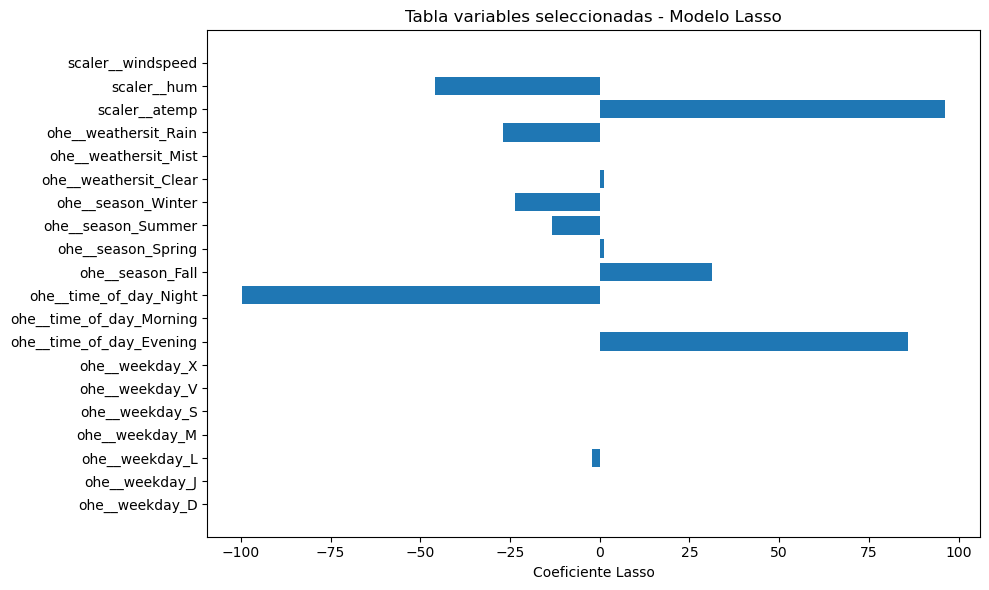

In [94]:
plt.figure(figsize=(10, 6))
plt.barh(x_train_prep.columns, lasso_sv.coef_)
plt.xlabel('Coeficiente Lasso')
plt.title('Tabla variables seleccionadas - Modelo Lasso')
plt.tight_layout()
plt.show()

In [93]:
seleccionadas_pos = ans[ans['Coeficiente'] > 0]['Variable'].tolist()
seleccionadas_neg = ans[ans['Coeficiente'] < 0]['Variable'].tolist()
print('Las variables seleccionadas por Lasso que aumentan el valor de la predicción son:')
for var in seleccionadas_pos:
    print(var.split("_")[-1])
print('Las variables que lo disminuyen son:')
for var in seleccionadas_neg:
    print(var.split("_")[-1])

Las variables seleccionadas por Lasso que aumentan el valor de la predicción son:
Evening
Fall
Spring
Clear
atemp
Las variables que lo disminuyen son:
L
Night
Summer
Winter
Rain
hum


Lo anterior es compatible con los resultados de correlación realizados al inicio y es consistente con el contexto del problema.
 
Las variables con coeficientes negativos, efectivamente son condiciones ambientales (noche, invierno, lluvia, humedad, verano) que pueden desalentar la decision de los usuarios de alquilar bicicletas. 
Mientras que las que presentaron coeficientes positivos (tarde, primavera, otoño, despejado y sensación de temperatura) representan condiciones criticas que inciden favorablemente en la decisión del usuario por esta actividad. El resultado de Lunes, puede verse influenciados por dias feriados por ejemplo, sin embargo hace falta mayor contexto sobre la recolección de datos para explicar ese resultado. 

Cabe notar, que aunque se tenia un desequilibrio notable entre los registros de clima despejado respecto a clima lluvioso, la presencia de lluvia tiene una influencia critica sobre la demanda. 

## 7. Comparación de modelos

Se construyó una tabla comparativa con los mejores modelos seleccionados (Regresión Polinomial y Lasso), evaluados sobre el conjunto de prueba utilizando las siguientes métricas:

- R²
- RMSE
- MAE

Esta comparación permite analizar cuál modelo presenta mejor capacidad predictiva y menor error, así como evaluar la capacidad de generalización sobre datos no vistos.


Mejor modelo regresión polinomial

In [42]:
y_pred = mejor_modelo_p.predict(x_test_prep)

print(f'------ Modelo de regresión polinomial ----')
print(f"RMSE: {root_mean_squared_error(y_test, y_pred):.2f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")
print(f'R²: {r2_score(y_test, y_pred):.2f}')

------ Modelo de regresión polinomial ----
RMSE: 130.52
MAE: 94.39
R²: 0.49


In [43]:
y_pred_train = mejor_modelo_p.predict(x_train_prep)
print(f'------ Modelo de regresión polinomial ----')
print(f"RMSE: {root_mean_squared_error(y_train,y_pred_train):.2f}")
print(f"MAE: {mean_absolute_error(y_train, y_pred_train):.2f}")
print(f'R²: {r2_score(y_train, y_pred_train):.2f}')

------ Modelo de regresión polinomial ----
RMSE: 123.83
MAE: 90.88
R²: 0.53


Se obtuvieron las métricas para el conjunto de test y train con el fin de verificar que no se presentará sobre ajuste. Se observa que hay buena generalización sobre los datos.

Mejor modelo Lasso

In [73]:
y_pred_l = mejor_modelo_l.predict(x_test_prep)

print(f'------ Modelo de regresión Lasso ----')
print(f"RMSE: {root_mean_squared_error(y_test, y_pred_l):.2f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_l):.2f}")
print(f'R²: {r2_score(y_test, y_pred_l):.2f}')

------ Modelo de regresión Lasso ----
RMSE: 136.19
MAE: 100.89
R²: 0.44


### Tabla comparativa entre mejores modelos

| Metricas | R. Polinomial (grado = 3) | Lasso (alpha = 1)|
|--------------|--------------|--------------|
| RMSE     | 130.52     | 136.19     |
| MAE   | 94.39     | 100.89      |
| R2  | 0.49    | 0.44     |

El modelo con mejor rendimiento es aquel cuyo valor de R2 es mayor y los valores de error RMSE/MAE son menores.

Teniendo en cuenta estos resultados, es posible afirmar que el modelo que presento un mejor rendimiento fue la Regresión Polinomial con grado 3. 

## 8. Análisis de resultados

A partir del proceso de validación:

- El grado seleccionado para la regresión polinomial fue: 3
- El valor óptimo de α para Lasso fue: 1

En términos de interpretación:

- Un valor alto de R² indica buena capacidad explicativa del modelo.
- Valores bajos de RMSE y MAE indican menor error promedio en la predicción.

Comparando el desempeño sobre el conjunto de prueba, se observa que el modelo de regresión polinomial de grado 3 ofrece el mejor equilibrio entre capacidad explicativa y error de predicción.

La transformación cúbica permite capturar relaciones no lineales más complejas entre las variables y la demanda. En particular, este tipo de modelo puede representar comportamientos donde la demanda aumenta hasta cierto punto y luego disminuye, lo cual es coherente con el comportamiento observado en variables como la temperatura.

Por ejemplo, a medida que la temperatura aumenta, la demanda de bicicletas también tiende a aumentar; sin embargo, cuando la temperatura es excesivamente alta, la demanda disminuye, de forma similar a lo que ocurre cuando la temperatura es demasiado baja. Este comportamiento no lineal es mejor representado por un modelo cúbico que por uno cuadrático o lineal.

En el caso del modelo Lasso, las variables seleccionadas permiten identificar los factores más relevantes en la demanda del sistema de bicicletas. Esto puede ser útil para diseñar estrategias de movilidad sostenible, optimizar la disponibilidad del servicio y mejorar la planificación operativa.




### Interpretación de variables seleccionadas por Lasso

El modelo Lasso incorporó una penalización L1, lo que permitió reducir a cero los coeficientes de aquellas variables con baja capacidad explicativa, conservando únicamente las que presentan mayor contribución predictiva sobre la demanda de bicicletas. De esta manera, el modelo no solo predice, sino que también realiza una selección automática de variables relevantes.

A partir de los coeficientes distintos de cero, se identificó que las condiciones meteorológicas son determinantes en la demanda. Variables como la humedad, la sensación térmica, la presencia de lluvia o cielo despejado presentan una influencia significativa. Esto sugiere que el comportamiento de los usuarios está altamente condicionado por factores climáticos.

Asimismo, se evidenció que la demanda varía según la estación del año. Se observaron niveles más bajos en verano e invierno, y un comportamiento más favorable en otoño. Esto puede asociarse a condiciones climáticas más templadas que favorecen el uso del servicio.

También se identificó influencia relacionada con la franja horaria del día, siendo el periodo de la tarde-noche (Evening) uno de los más explicativos. Esto puede relacionarse con patrones de movilidad laboral o recreativa, donde las bicicletas se utilizan como medio de transporte alternativo en horarios de salida del trabajo o actividades sociales.

### Implicaciones para la toma de decisiones

Estos hallazgos permiten plantear estrategias orientadas a optimizar la operación del sistema. Por ejemplo:

- Implementar tarifas promocionales en horarios o estaciones de baja demanda (invierno o franjas nocturnas).
- Ajustar la disponibilidad de bicicletas según estación y horario.
- Desarrollar eventos que incentiven el uso en periodos de menor demanda.
- Invertir en infraestructura que mitigue el impacto de la lluvia, como estaciones cubiertas o tramos protegidos.

### Posibles mejoras del análisis

Dado que la demanda disminuye significativamente ante condiciones de lluvia y alta humedad, sería recomendable ampliar la cantidad de datos en estas condiciones para mejorar la capacidad predictiva del modelo en escenarios extremos.

Adicionalmente, podría incorporarse información geográfica (zonas de alto tránsito o concentración de usuarios). Esto permitiría complementar el modelo actual, centrado en variables temporales y climáticas, con una dimensión espacial que facilite decisiones sobre expansión de infraestructura, ubicación estratégica de estaciones y redistribución de bicicletas, fortaleciendo así la movilidad sostenible en la ciudad.
